<a href="https://colab.research.google.com/github/lukaszplust/Machine-Learning/blob/main/neural_nets_lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Visualisation_utilis

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def inspect_data(x, y, show_first_n=4, x_test=None, y_test=None):
    print(f'{x.shape=}, {y.shape=}')
    if x_test is not None and y_test is not None:
        print(f'{x_test.shape=}, {y_test.shape=}')
    print(f'First {show_first_n} (x, y) data pairs:')
    for xi, yi in zip(x[:show_first_n], y[:show_first_n]):
        print(f'{xi} => {yi}')


def visualize_activation_function(func):
    logits = np.linspace(-10, 10, 1001)

    plt.axhline(y=0, color="gray", linestyle="-")
    plt.axhline(y=1.0, color="gray", linestyle="--")
    plt.axhline(y=-1.0, color="gray", linestyle="--")
    plt.axvline(color="gray")
    plt.plot(logits, func(logits), 'r-', linewidth=3)
    plt.ylim(-1.2, 1.2)
    plt.title(f'Function: {func.__name__}'); plt.xlabel('logits'); plt.ylabel('y');
    plt.show()


def x_data_from_grid(min_xy, max_xy, grid_size, dtype=np.float32):
    values = np.linspace(min_xy, max_xy, grid_size, dtype=dtype)
    X1, X2 = np.meshgrid(values, values)
    return np.hstack((X1.reshape((X1.size, 1)), X2.reshape((X2.size, 1)))).astype(dtype)


def plot_data(x, y, ax=None, plot_xy_range=None, x_grid=None, y_grid=None,
              add_bar=True, axes_lines=True, x_test=None, y_test=None,
              x1_label='x1', x2_label='x2', title='Input space', do_show=True):

    if ax is None:
        ax = plt.gca()
    plt.sca(ax)
    plt.cla()

    if plot_xy_range is not None:
        xlims = ylims = np.array(plot_xy_range)
    else:
        xlims = ylims = np.array([np.min(x[:, 0]), np.max(x[:, 1])])

    if x_grid is not None and y_grid is not None:
        grid_size = int(np.sqrt(x_grid.shape[0]))
        x1_grid = x_grid[:, 0].reshape((grid_size, grid_size))
        x2_grid = x_grid[:, 1].reshape((grid_size, grid_size))
        y_grid = y_grid.reshape((grid_size, grid_size))
        CS = ax.contourf(x1_grid, x2_grid, y_grid, np.linspace(0., 1., 51),
                         alpha=.8, cmap=plt.cm.get_cmap("bwr"))
        decision_line = plt.contour(CS, levels=[0.5], colors='k')
        if add_bar:
            cbar = plt.colorbar(CS)
            cbar.add_lines(decision_line)
            cbar.ax.set_ylabel('output value')

    if axes_lines is True:
        plt.axhline(y=0, color="gray", linestyle=":")
        plt.axvline(x=0, color="gray", linestyle=":")

    ax.scatter(x[:, 0], x[:, 1], c=y.flatten(), s=40, cmap=plt.cm.get_cmap("bwr"), edgecolors='k',
               label='Kółka: Train')

    if x_test is not None and y_test is not None:
        ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test.flatten(), marker='s',
                   s=40, cmap=plt.cm.get_cmap("bwr"), edgecolors='k', label='Kwadraty: Test')
        plt.legend()
    plt.xlabel(x1_label)
    plt.ylabel(x2_label)
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.title(title)
    if do_show:
        plt.show()


def plot_two_layer_activations(model, x, y):
    x_grid = x_data_from_grid(min_xy=-1, max_xy=2, grid_size=1000)
    h_data = model.hidden_layer.forward(x)
    h_grid = model.hidden_layer.forward(x_grid)
    y_pred_grid = model.forward(x_grid)
    y_in_hidden_grid = model.output_layer.forward(x_grid)

    fig, axs = plt.subplots(2, 2)
    plot_data(x, y, ax=axs[0, 0], x_grid=x_grid, y_grid=h_grid[:, 0], plot_xy_range=[-1, 2], do_show=False,
              title='h1', add_bar=False)
    plot_data(x, y, ax=axs[0, 1], x_grid=x_grid, y_grid=h_grid[:, 1], plot_xy_range=[-1, 2], do_show=False,
              title='h2', add_bar=False)
    plot_data(h_data, y, ax=axs[1, 0], x_grid=x_grid, y_grid=y_in_hidden_grid, plot_xy_range=[-1, 2], do_show=False,
              x1_label='h1', x2_label='h2', title='y in hidden space', add_bar=False)
    plot_data(x, y, ax=axs[1, 1], x_grid=x_grid, y_grid=y_pred_grid, plot_xy_range=[-1, 2], do_show=False,
              title='y in input space', add_bar=False)
    for ax in axs.flatten():
        ax.set_aspect('equal', 'box')
    fig.tight_layout()
    plt.show()

# data.py

In [2]:
import numpy as np
import math
from abc import ABC, abstractmethod


class DataGenerator(ABC):
    @abstractmethod
    def generate_data(self, n_examples: int, *args, **kwargs):
        pass


class ClassificationTwoSpiralsData(DataGenerator):
    def __init__(self, degrees=570, start=40, min_x=-12, max_x=12):
        """
        Adopted from Matlab code at:
            http://www.mathworks.com/matlabcentral/fileexchange/
            41459-6-functions-for-generating-artificial-datasets/content/twospirals.m

        :type degrees: int
        :param degrees: length of the spirals

        :type start: int
        :param start: how far from the origin the spirals start, in degrees

        :param min_x:
        :param max_x:
        """
        super().__init__()
        self.degrees = degrees
        self.start = start
        self.min_x = min_x
        self.max_x = max_x

    def generate_data(self, n_examples=2000, noise=0.5, seed=1234, **kwargs):
        """
        :type n_examples: int
        :param n_examples: number of instances
        :type noise: float
        :param noise: 0 is no noise, at 1 the spirals will start to overlap
        :type seed: int
        :param seed:
        """

        deg2rad = 2. * math.pi / 360.
        start = self.start * deg2rad

        N1 = int(math.floor(n_examples / 2))
        N2 = n_examples - N1

        rng = np.random.RandomState(seed)

        n = start + np.sqrt(rng.rand(N1)) * self.degrees * deg2rad
        d1 = np.column_stack((-np.cos(n) * n + rng.rand(N1) * noise,
                              np.sin(n) * n + rng.rand(N1) * noise, np.zeros_like(n)))

        n = start + np.sqrt(rng.rand(N2)) * self.degrees * deg2rad
        d2 = np.column_stack((np.cos(n) * n + rng.rand(N2) * noise,
                              -np.sin(n) * n + rng.rand(N2) * noise, np.ones_like(n)))

        d = np.vstack((d1, d2))

        order = np.arange(len(d))
        rng = np.random.RandomState(seed)
        rng.shuffle(order)
        d = d[order]
        data_x = d[:, 0:2].astype(np.float32)
        data_labels = d[:, 2]
        data_labels = data_labels.reshape(data_labels.size, 1).astype(np.float32)

        min_data_x = np.min(data_x)
        max_data_x = np.max(data_x)
        data_x = (data_x - min_data_x)/(max_data_x - min_data_x) * 2. - 1.

        return data_x, data_labels


class LogicGateData(DataGenerator):
    def __init__(self, gate_type='xor', dtype=np.float32):
        super().__init__()
        supported_gate_types = ['or', 'nor', 'xor', 'and', 'nand']
        if gate_type not in supported_gate_types:
            raise ValueError(f'Not supported gate type {gate_type}. Choose one of: {supported_gate_types}')
        self._gate_type = gate_type
        self.dtype = dtype

    def generate_data(self, **kwargs):
        x_data = np.array([[0, 0],
                           [0,  1],
                           [ 1, 0],
                           [ 1,  1]], dtype=np.float32)
        if self._gate_type == 'xor':
            labels = np.logical_xor(x_data[:, 0], x_data[:, 1])
        elif self._gate_type == 'and':
            labels = np.logical_and(x_data[:, 0], x_data[:, 1])
        elif self._gate_type == 'nand':
            labels = 1 - np.logical_and(x_data[:, 0], x_data[:, 1])
        elif self._gate_type == 'nor':
            labels = 1 - np.logical_or(x_data[:, 0], x_data[:, 1])
        else:
            labels = np.logical_or(x_data[:, 0], x_data[:, 1])

        return x_data, labels.astype(self.dtype).reshape((4, 1))


class RotatedLogicGateData(LogicGateData):
    def __init__(self, gate_type='xor',  dtype=np.float32):
        super().__init__(gate_type=gate_type, dtype=dtype)

    def generate_data(self, seed, **kwargs):
        x_data, labels = super().generate_data()
        if seed is not None:
            np.random.seed(seed)
        x_data, labels = np.tile(x_data, (10, 1)), np.tile(labels, (10, 1))
        x_data += 0.2*np.random.rand(x_data.shape[0], 2) - 0.1
        theta = np.radians(np.random.randint(360))
        c, s = np.cos(theta), np.sin(theta)
        R = np.array([[c, -s], [s, c]])

        return (x_data - 0.5) @ R + 0.5, labels


class LinearlySeparableClasses(RotatedLogicGateData):
    def __init__(self):
        super().__init__(gate_type='and')


class NonlinearlySeparableClasses(RotatedLogicGateData):
    def __init__(self):
        super().__init__(gate_type='xor')


def input_noise(datax, noise_level=0.01, dtype=np.float32):
    noisy_datax = datax + noise_level * np.random.randn(datax.size).reshape(datax.shape).astype(dtype)
    return noisy_datax


def label_noise(labels, noise_level=0.05, dtype=np.float32):
    r = np.random.rand(labels.size).reshape(labels.shape) < noise_level
    noisy_labels = np.logical_xor(labels, r).astype(dtype)
    return noisy_labels


Na wykresie:

kropki --> probki danych

kolor --> poziom aktywacji dla danego neuronu

Jasny kolor może oznaczać wysoką aktywację, a ciemny kolor niską

#part_1_net_architekture_in_numpy.py

In [32]:
import numpy as np
# Przykładowe funkcje aktywacji

def relu(logits):
    return np.maximum(logits, 0)

def sigmoid(logits):
    return 1. / (1. + np.exp(-logits))
    # return np.exp(-np.logaddexp(0, -logits))     # to samo co wyżej, ale stabilne numerycznie

def hardlim(logits):
    return (logits > 0).astype(np.float32)
    # return np.round(sigmoid(logits))             # to samo co wyżej, bez wykorzystywania porównań i rzutowań

def linear(logits):
    return logits


def zad1_single_neuron(student_id):
    gen = LinearlySeparableClasses()
    x, y = gen.generate_data(seed=student_id)
    n_samples, n_features = x.shape

    # zakomentuj, jak juz nie potrzebujesz
    inspect_data(x, y)
    plot_data(x, y, plot_xy_range=[-1, 2])

    # model pojedynczego neuronu
    class SingleNeuron:
        def __init__(self, n_in, f_act):

            # wagi neuronu
            self.W = 0.01 * np.random.randn(n_in, 1)  # rozmiar W: [n_in, 1]
            # przesuniecie - bias
            self.b = 0.01 * np.random.randn(1)  # rozmiar b: [1]
            # funkcja aktywacji neuronu
            self.f_act = f_act

        # propagacja wprzód

        # propagacja to proces, w którym dane są przekazywane przez warstwy sieci neuronowej,
        # od warstwy wejściowej do warstwy wyjściowej

        def forward(self, x_data):
            """
            # n_samples = liczba probek
            # n_in = liczba cech wejsciowych
            # x_data = macierz danych wejsciowych

            :param x_data: wejście neuronu: np.array o rozmiarze [n_samples, n_in]
            :return: wyjście neuronu: np.array o rozmiarze [n_samples, 1]
            """

            # TODO (0.5 point)

            # obliczenie logitu

            logits = np.dot(x_data, self.W) + self.b
            return self.f_act(logits)

    # neuron zainicjowany losowymi wagami
    model = SingleNeuron(n_in=n_features, f_act=hardlim)

    # TODO: ustawienie właściwych wag (0.5 point)
    # model.W[:, 0] = [w1, w2]
    # model.b[:] = [b1]

    model.W[:, 0] = [1, -1]
    model.b[:] = [-0.5]

    # działanie i ocena modelu
    y_pred = model.forward(x)
    print(f'Accuracy = {np.mean(y == y_pred) * 100}%')

    # test na całej przestrzeni wejść (z wizualizacją)

    # siatka punktu danych wejsciowych rownomiernie rozlozona od -1 do 2
    x_grid = x_data_from_grid(min_xy=-1, max_xy=2, grid_size=1000)

    #linia decyzyjna na całej przestrzeni siatki
    y_pred_grid = model.forward(x_grid)

    # dane treningowe
    # x to macierz cech danych wejściowych, a y to wektor etykiet klas dla tych danych
    plot_data(x, y, plot_xy_range=[-1, 2], x_grid=x_grid, y_grid=y_pred_grid, title='Linia decyzyjna neuronu')

x.shape=(40, 2), y.shape=(40, 1)
First 4 (x, y) data pairs:
[-0.25750927  0.55665722] => [0.]
[0.52147437 1.21513362] => [0.]
[ 0.32519373 -0.19871544] => [0.]
[1.17121503 0.31373043] => [1.]


<ipython-input-1-85400e56c64a>:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.scatter(x[:, 0], x[:, 1], c=y.flatten(), s=40, cmap=plt.cm.get_cmap("bwr"), edgecolors='k',


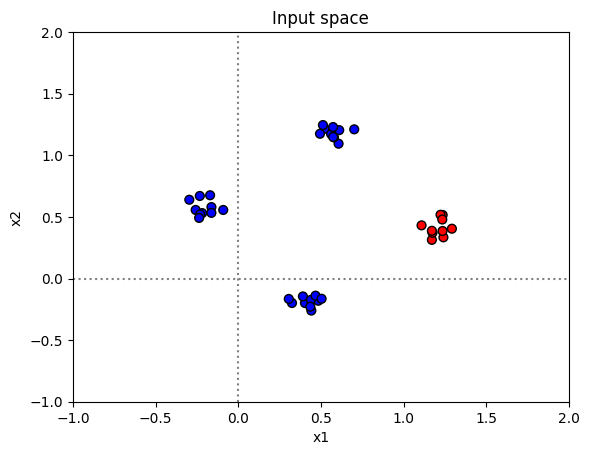

Accuracy = 77.5%


<ipython-input-1-85400e56c64a>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  alpha=.8, cmap=plt.cm.get_cmap("bwr"))


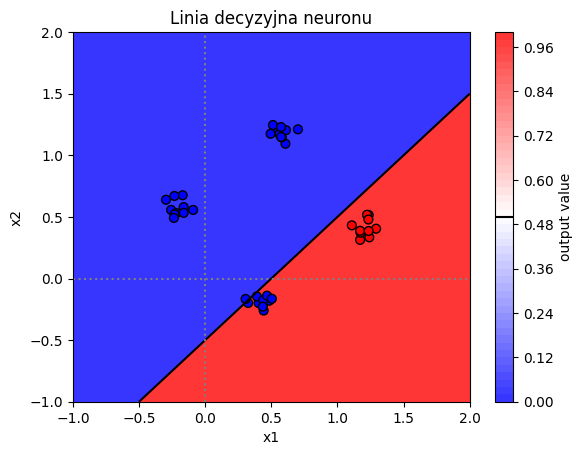

In [33]:
student_id = 186437        # Twój numer indeksu, np. 102247
zad1_single_neuron(student_id)

In [43]:
def zad2_two_layer_net(student_id):
    gen = NonlinearlySeparableClasses()
    x, y = gen.generate_data(seed=student_id)
    n_samples, n_features = x.shape

    # zakomentuj, jak juz nie potrzebujesz
    #inspect_data(x, y)
    #plot_data(x, y, plot_xy_range=[-1, 2])

    # warstwa czyli n_out pojedynczych, niezależnych neuronów operujących na tym samym wejściu\
    # (i-ty neuron ma swoje parametry w i-tej kolumnie macierzy W i na i-tej pozycji wektora b)
    class DenseLayer:
        def __init__(self, n_in, n_out, f_act):
            self.W = 0.01 * np.random.randn(n_in, n_out)  # rozmiar W: ([n_in, n_out])
            self.b = 0.01 * np.random.randn(n_out)  # rozmiar b  ([n_out])
            self.f_act = f_act

        def forward(self, x_data):
            logits = np.dot(x_data, self.W) + self.b
            return self.f_act(logits)

    # TODO: warstwy mozna składać w wiekszy model
    class SimpleTwoLayerNetwork:

        # n_in = liczba neuronow wejsciowych
        # n_out = liczba neuronow wyjsciowych
        # n_hidden = liczba neurowno w warstwie ukrytej

        def __init__(self, n_in, n_hidden, n_out):
            self.hidden_layer = DenseLayer(n_in, n_hidden, f_act=hardlim) # korzystam z funkcji aktywacji hardlim
            self.output_layer = DenseLayer(n_hidden, n_out, f_act=hardlim) # korzystam z funkcji aktywacji hardlim

        def forward(self, x_data):

          hidden_activ = self.hidden_layer.forward(x_data)
          output_activ = self.output_layer.forward(hidden_activ)
          return output_activ

    # model zainicjowany losowymi wagami
    model = SimpleTwoLayerNetwork(n_in=n_features, n_hidden=2, n_out=1)

    # TODO: ustawienie właściwych wag
    # model.hidden_layer.W[:, 0] = None      # wagi neuronu h1
    # model.hidden_layer.W[:, 1] = None      # wagi neuronu h2
    # model.hidden_layer.b[:] = None         # biasy neuronów h1 i h2
    # model.output_layer.W[:, 0] = None      # wagi neuronu wyjściowego
    # model.output_layer.b[:] = None         # bias neuronu wyjściowego

    model.hidden_layer.W[:, 0] = [1.2, 0.8]    # nowe wagi dla neuronu h1
    model.hidden_layer.W[:, 1] = [1.4, 1.2]    # nowe wagi dla neuronu h2
    model.hidden_layer.b[:] = [-1.5, -0.5]     # nowe biasy dla neuronów h1 i h2
    model.output_layer.W[:, 0] = [1.5, -1.5]  # nowe wagi dla neuronu wyjściowego
    model.output_layer.b[:] = [0.5]           # nowy bias dla neuronu wyjściowego


    # działanie i ocena modelu
    y_pred = model.forward(x)
    print(f'Accuracy = {np.mean(y == y_pred) * 100}%')

    plot_two_layer_activations(model, x, y)

Accuracy = 52.5%


<ipython-input-1-85400e56c64a>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  alpha=.8, cmap=plt.cm.get_cmap("bwr"))
<ipython-input-1-85400e56c64a>:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.scatter(x[:, 0], x[:, 1], c=y.flatten(), s=40, cmap=plt.cm.get_cmap("bwr"), edgecolors='k',


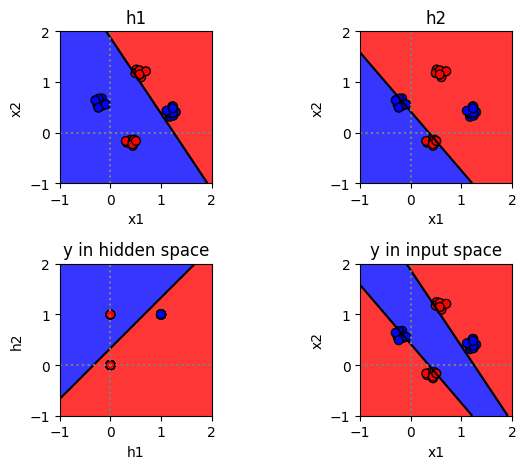

In [45]:
# visualize_activation_function(relu)

student_id = 186437        # Twój numer indeksu, np. 102247

zad2_two_layer_net(student_id)

#part_2_net_training_in_pytorch.py

x.shape=(800, 2), y.shape=(800, 1)
x_test.shape=(200, 2), y_test.shape=(200, 1)
First 4 (x, y) data pairs:
[-0.24767876 -0.7716336 ] => [1.]
[-0.2580055   0.06420934] => [1.]
[-0.66211355  0.47085512] => [0.]
[-0.7777397  0.313048 ] => [0.]


<ipython-input-1-85400e56c64a>:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.scatter(x[:, 0], x[:, 1], c=y.flatten(), s=40, cmap=plt.cm.get_cmap("bwr"), edgecolors='k',
<ipython-input-1-85400e56c64a>:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  s=40, cmap=plt.cm.get_cmap("bwr"), edgecolors='k', label='Kwadraty: Test')


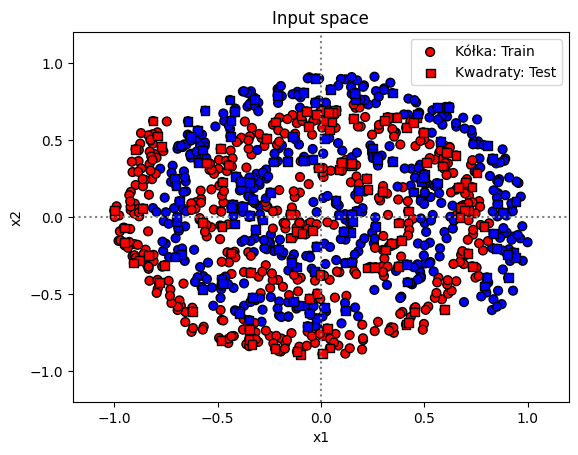

TorchMultiLayerNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)
Aktualne wagi:
layers.0.weight tensor([[ 0.5654, -0.1223],
        [ 0.1187, -0.2454],
        [ 0.1423,  0.3219],
        [-0.3975, -0.6260],
        [-0.6980,  0.5698],
        [-0.6214,  0.3248],
        [ 0.4671,  0.3939],
        [-0.3756, -0.2951],
        [-0.1351, -0.5812],
        [ 0.0283, -0.4670],
        [-0.3705,  0.6665],
        [-0.3629,  0.6760],
        [-0.4724, -0.3988],
        [ 0.5831,  0.6905],
        [ 0.4524,  0.6050],
        [ 0.3936, -0.6807]])
layers.0.bias tensor([ 0.5619,  0.5264, -0.5054,  0.6792,  0.3097, -0.5696, -0.6139, -0.2274,
        -0.6204, -0.5511,  0.4266,  0.3303, -0.0867,  0.5881, -0.4075, -0.

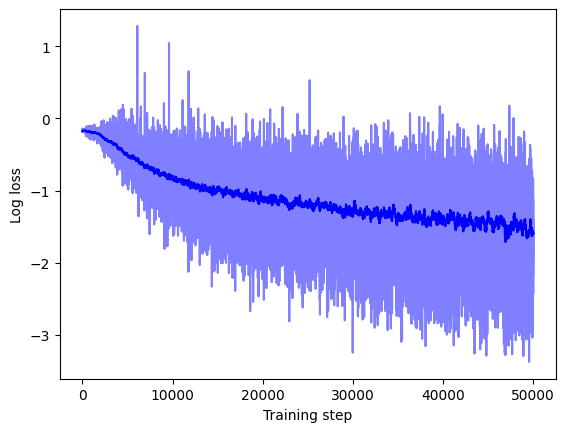

Model saved to my_model.pkl.
Train accuracy: 98.50%
Test accuracy: 91.50%


<ipython-input-1-85400e56c64a>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  alpha=.8, cmap=plt.cm.get_cmap("bwr"))


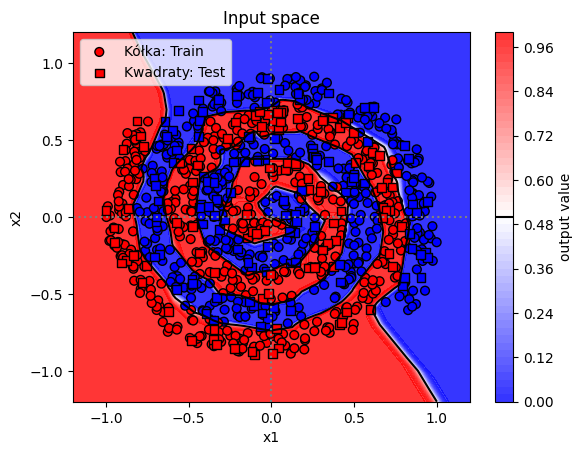

In [47]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


class TorchMultiLayerNetwork(nn.Module):
    """
    Prosta sieć neuronowa w pyTorch o parametryzowalnej liczbie warstw ukrytych.
    Konstrukcja analogiczna, jak dwuwarstwowej sieci z części pierwszej.

    Np. dla n_in=2, n_hiddens=[10, 20] i n_out=1 powstanie sieć z dwoma wejściami, pierwszą warstwą ukrytą z 10
    neuronami, drugą warstwą ukrytą z 20 neuronami i jednym neuronem w warstwie wyjściowej. Funkcje aktywacji
    ustawione "na sztywno": 'relu' w warstwach ukrytych i 'sigmoid' w warstwie wyjściowej.
    """

    def __init__(self, n_in, n_hiddens, n_out):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(n_i, n_o) for n_i, n_o in zip([n_in] + n_hiddens, n_hiddens + [n_out])])

    def forward(self, x_data):
        x = x_data
        for l in self.layers[:-1]:
            x = F.relu(l(x))
        return F.sigmoid(self.layers[-1](x))


def evaluate_model(model, x, y):
    with torch.no_grad():                       # przy ewaluacji nie ma potrzeby liczyć gradientów
        y_pred = torch.round(model.forward(x))
        acc = (y == y_pred).sum().item() / y.shape[0]
    return acc


def training(model, x, y):

    # training hiperparameters
    n_steps = 50000
    learning_rate = 0.1        # try different values
    minibatch_size = 32

    loss_fn = F.binary_cross_entropy

    history = []; i_step=0

    # pętla uczenia gradientowego
    for _ in range(n_steps):

        # TODO losowa paczka (mini-batch) danych o rozmiarze minibatch_size
        #  (użyj torch.randint do wylosowania indeksów przykładów

        # W wersji tej, w każdym obiegu
        #  pętli optymalizacji, liczona jest wartość funkcji kosztu, a następnie gradient, na
        #  podstawie losowego podzbioru danych treningowych (podzbiór zawiera jedynie BS danych)


        index = torch.randint(0, x.shape[0], (minibatch_size,))

        x_batch = x[index]
        y_batch = y[index]

        # TODO forward pass modelu + policzenie wartości funkcji kosztu (użyj loss_fn zdefiniowanego wyżej)

        output = model(x_batch)
        loss = loss_fn(output, y_batch)


        # backward pass
        for p in model.parameters():
            p.grad = None  # gradienty są akumulowane, więc przed następnym krokiem trzeba je zresetować (specyfika pyTorch)
        loss.backward()  # autograd - policzenie gradientów metodą wstecznej propagacji - wypełnia pola .grad każdego
                         # z parametrów, który wpływa na wartość loss

        # TODO update params

        with torch.no_grad():
          for param in model.parameters():
            param -= learning_rate * param.grad

        # track stats
        history.append(loss.log10().item())
        i_step += 1
        if i_step % 1000 == 0:
            print(f'Step={i_step}, lr={learning_rate:.6f}, loss={loss.item():.6f}')

    return model, history


def plot_history(history, smoothing_factor=0.99):
    plt.plot(history, c='b', alpha=0.5)
    if smoothing_factor is not None:
        smoothed_history = []; pv = history[0]
        for v in history:
            smoothed_history.append(smoothed := smoothing_factor*pv + (1.0-smoothing_factor)*v)
            pv = smoothed
        plt.plot(smoothed_history, c='b')
    plt.xlabel('Training step')
    plt.ylabel('Log loss')
    plt.show()


def classify_spirals(student_id, do_data_inspection=True, do_model_inpection=True, do_model_training=True,
                     load_trained_model=False):

    model_path = "my_model.pkl"

    # generacja danych
    n_examples = 1000
    gen = ClassificationTwoSpiralsData(degrees=900)
    x, y = gen.generate_data(n_examples=n_examples, noise=3.0, seed=student_id)

    # podział na zbiór uczący i testowy:
    n_train = int(0.8 * n_examples)
    x_train, y_train = x[:n_train], y[:n_train]
    x_test, y_test = x[n_train:], y[n_train:]

    if do_data_inspection:
        inspect_data(x_train, y_train, x_test=x_test, y_test=y_test)
        plot_data(x, y, x_test=x_test, y_test=y_test, plot_xy_range=[-1.2, 1.2])

    # konwersja danych do torch.Tensor
    x_train, y_train, x_test, y_test = [torch.from_numpy(x) for x in [x_train, y_train, x_test, y_test]]

    # utworzenie modelu
    model = TorchMultiLayerNetwork(
        n_in=2,
        n_hiddens=[16, 32, 32, 16],
        n_out=1)

    if load_trained_model:
        model.load_state_dict(torch.load(model_path))
        print(f"Wagi modelu załadowane z {model_path}")

    if do_model_inpection:
        print(model)
        print("Aktualne wagi:")
        for name, param in model.named_parameters():
            print(name, param.data)                 # początkowo wagi losowe
        print("Aktualne gradienty:")
        for name, param in model.named_parameters():
            print(name, param.requires_grad)        # czy dla tego parametru będzie potrzebne liczenie gradientu
            print(name, param.grad)                 # aktualna wartość gradientu

    print(f'Train accuracy: {evaluate_model(model, x_train, y_train) * 100:.02f}%')
    print(f'Test accuracy: {evaluate_model(model, x_test, y_test) * 100:.02f}%')

    if do_model_training:
        model, history = training(model,
                                  x_train,
                                  y_train)
        plot_history(history)
        torch.save(model.state_dict(), model_path)
        print(f"Model saved to {model_path}.")

    # ewaluacja po treningu
    print(f'Train accuracy: {evaluate_model(model, x_train, y_train) * 100:.02f}%')
    print(f'Test accuracy: {evaluate_model(model, x_test, y_test) * 100:.02f}%')

    # test na całej przestrzeni wejść (z wizualizacją)
    x_grid = x_data_from_grid(min_xy=-1.2, max_xy=1.2, grid_size=1000)
    with torch.no_grad():
        y_pred_grid = model.forward(torch.from_numpy(x_grid))
    plot_data(x_train, y_train, x_test=x_test, y_test=y_test,
              plot_xy_range=[-1.2, 1.2], x_grid=x_grid, y_grid=y_pred_grid.numpy())


if __name__ == '__main__':

    student_id = 186437        # Twój numer indeksu, np. 102247
    torch.manual_seed(student_id)

    classify_spirals(student_id,
                     do_data_inspection=True,
                     do_model_inpection=True,
                     do_model_training=True,
                     load_trained_model=False)
